# wps-pipeline-notebook

This is jupyter notebook for the example use of the wps services that are provided by the GFZ in the RIESGOS project.


In [1]:
%load_ext autoreload
%autoreload 2
import owslib.wps as wps
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import numpy as np
import lxml.etree as le
from mpl_toolkits.basemap import Basemap
import gfzwpsformatconversions
import ipyleaflet as ipyl
import ipywidgets as ipyw
#
%matplotlib inline

/home/mruester/git/RIESGOS/gfzriesgos/wps-pipeline-notebook/wps-pipeline-notebook/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
WPS_URL = 'http://rz-vm140.gfz-potsdam.de/wps/WebProcessingService'

In [3]:
server = wps.WebProcessingService(WPS_URL)

So lets see what processes are supported:

In [4]:
server.processes

[<owslib.wps.Process org.n52.wps.server.algorithm.r.AnnotationValidation>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.ShakemapTransformationProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.ShakygroundProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.QuakeledgerProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.CachedVolcanusProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.QuakeMLTransformationProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.ShakemapCacheReader>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.QuakeMLCacheReader>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.VolcanusProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.CachedAssetmasterProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.CachedOldAssetmasterProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.CachedModelpropProcess>,
 <owslib.wps.Process org.n52.gfz.ries

Some of them are test processes, some others are included by default.
We will focus on the following:

| Process | Use case |
|---------|----------|
| Assetmaster | Extraction of the exposure model for a given location |
| Modelprop | Extraction of the vulnerability model with the fragility functions |
| Quakeledger | Earth quake catalog that we use to search for specific events |
| Shakyground | Computation of the pga for a given event |
| Deus | Update of the exposure model with damage states after using the intensities of a given event |

The processes are following a pipeline.

1. Assetmaster
2. Modelprop
3. Quakeledger
4. Shakyground
5. Deus

The order for assetmaster, modelprop and quakeledger can change is not strongly needed. They can be used in any order. However we need to use quakeledger before shakyground and we have to use all other processes before deus (as it needs the exposure model, the fragility functions and the intenstities computed in shakyground).

## Assetmaster
We will start working with the assetmaster dataset.

In [5]:
ID_ASSETMASTER = 'org.n52.gfz.riesgos.algorithm.impl.AssetmasterProcess'

In [6]:
execution_assetmaster = server.execute(
    identifier=ID_ASSETMASTER, 
    inputs=[
        ('lonmin', '-71.8'),
        ('lonmax', '-71.4'),
        ('latmin', '-33.2'),
        ('latmax', '-33.0'),
        ('schema', 'SARA_v1.0'),
        ('assettype', 'res'),
        ('querymode', 'intersects')
    ],
    output=[('selectedRowsGeoJson', True)]
)

wps.monitorExecution(execution_assetmaster)
print('Successful: {}'.format(execution_assetmaster.isSucceded()))

Successful: True


In [7]:
assetmaster_output_reference = execution_assetmaster.processOutputs[0].reference
assetmaster_output_pure = requests.get(assetmaster_output_reference).text
assetmaster_output = gpd.read_file(assetmaster_output_reference)

In [8]:
assetmaster_output.head()

,gid,name,expo,geometry
0,100,None,"{'Taxonomy': {'11': 'MUR-ADO-H1-2', '12': 'MUR...","MULTIPOLYGON (((-71.48738 -32.99569, -71.48628..."
1,1002,None,"{'Taxonomy': {'11': 'MUR-ADO-H1-2', '12': 'MUR...","MULTIPOLYGON (((-71.49692 -33.19048, -71.52102..."
2,1003,None,"{'Taxonomy': {'11': 'MUR-ADO-H1-2', '12': 'MUR...","MULTIPOLYGON (((-71.52951 -32.99708, -71.52926..."
3,1004,None,"{'Taxonomy': {'11': 'MUR-ADO-H1-2', '12': 'MUR...","MULTIPOLYGON (((-71.52717 -33.01308, -71.52598..."
4,1005,None,"{'Taxonomy': {'11': 'MUR-ADO-H1-2', '12': 'MUR...","MULTIPOLYGON (((-71.54862 -33.08271, -71.54903..."


In [9]:
pd.DataFrame(assetmaster_output.iloc[0].expo)

,Taxonomy,Buildings,Population,Repl-cost-USD-bdg,id,Damage,Dwellings
11,MUR-ADO-H1-2,12,37,945000,100,D0,11
12,MUR-H1-3,23,71,1207500,100,D0,22
13,MUR-STDRE-H1-2,2,6,87500,100,D0,2
14,W-WLI-H1-3,75,228,13500000,100,D0,70
15,W-WS-H1-2,37,114,2913750,100,D0,35
0,CR-LWAL-DNO-H1-3,12,36,3456000,100,D0,11
1,CR-LWAL-DNO-H4-7,1,3,1080000,100,D0,1
2,CR-LWAL-DUC-H1-3,4,12,1344000,100,D0,4
3,CR-LWAL-DUC-H4-7,1,2,1260000,100,D0,1
4,CR-LWAL-DUC-H8-19,0,1,0,100,D0,0


### TODO
Add a basemap for the cells.

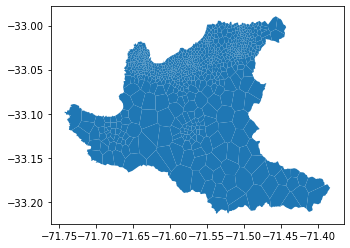

In [10]:
assetmaster_output.plot()

## Modelprop
Next is the modelprop process.

In [11]:
ID_MODELPROP = 'org.n52.gfz.riesgos.algorithm.impl.ModelpropProcess'

In [12]:
execution_modelprop = server.execute(
    identifier=ID_MODELPROP, 
    inputs=[
        ('schema', 'SARA_v1.0'),
        ('assetcategory', 'buildings'),
        ('losscategory', 'structural'),
        ('taxonomies', ''),
    ],
    output=[('selectedRows', True)]
)

wps.monitorExecution(execution_modelprop)
print('Successful: {}'.format(execution_modelprop.isSucceded()))

Successful: True


In [13]:
modelprop_output_reference = execution_modelprop.processOutputs[0].reference
modelprop_output_pure = requests.get(modelprop_output_reference).text
modelprop_output = requests.get(modelprop_output_reference).json()

In [14]:
str(modelprop_output)[:3000]

"{'data': [{'D3_mean': -0.496, 'taxonomy': 'MUR-H1', 'D1_3_mean': -2.648, 'D2_3_mean': -3.166, 'D3_4_stddev': 0.322, 'imu': 'g', 'im_max': 3.0, 'D2_mean': -0.709, 'imt': 'PGA', 'D2_4_stddev': 0.328, 'D2_3_stddev': 0.328, 'id': 'unique_id', 'D1_4_stddev': 0.31, 'D1_stddev': 0.31, 'D1_4_mean': -2.24, 'D2_4_mean': -2.218, 'D3_4_mean': -2.532, 'D1_mean': -1.418, 'D2_stddev': 0.328, 'D4_mean': -0.231, 'D4_stddev': 0.317, 'D3_stddev': 0.322, 'im_min': 0.0, 'D1_2_mean': -3.032, 'D1_2_stddev': 0.31, 'D1_3_stddev': 0.31}, {'D3_mean': -0.496, 'taxonomy': 'ER-ETR-H1-2', 'D1_3_mean': -2.648, 'D2_3_mean': -3.166, 'D3_4_stddev': 0.322, 'imu': 'g', 'im_max': 3.0, 'D2_mean': -0.709, 'imt': 'PGA', 'D2_4_stddev': 0.328, 'D2_3_stddev': 0.328, 'id': 'unique_id', 'D1_4_stddev': 0.31, 'D1_stddev': 0.31, 'D1_4_mean': -2.24, 'D2_4_mean': -2.218, 'D3_4_mean': -2.532, 'D1_mean': -1.418, 'D2_stddev': 0.328, 'D4_mean': -0.231, 'D4_stddev': 0.317, 'D3_stddev': 0.322, 'im_min': 0.0, 'D1_2_mean': -3.032, 'D1_2_stdde

In [15]:
urm1_functions = [x for x in modelprop_output['data'] if x['taxonomy'] == 'MUR-H1'][0]

In [16]:
cdf_urm1_d4 = lognorm(scale=np.exp(urm1_functions['D4_mean']), s=urm1_functions['D4_stddev']).cdf

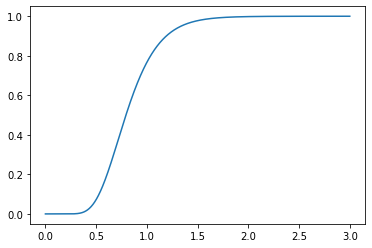

In [17]:
xs = np.linspace(0, 3, 1000)
ys = cdf_urm1_d4(xs)
plt.plot(xs, ys)

## Quakeledger
Now we are interested in the events in our region.

In [18]:
ID_QUAKELEDGER = 'org.n52.gfz.riesgos.algorithm.impl.QuakeledgerProcess'

In [19]:
execution_quakeledger = server.execute(
    identifier=ID_QUAKELEDGER, 
    inputs=[
        ('input-boundingbox', wps.BoundingBoxDataInput([-70, 288 - 360, -10, 292 - 360], 'EPSG:4326')),
        ('mmin', '6.6'),
        ('mmax', '8'),
        ('zmin', '5'),
        ('zmax', '140'),
        ('p', '140'),
        ('etype', 'expert'),
        ('tlon', '-71.5730623712764'),
        ('tlat', '-33.1299174879672'),
    ],
    output=[('selectedRows', True)]
)

wps.monitorExecution(execution_quakeledger)
print('Successful: {}'.format(execution_quakeledger.isSucceded()))

Successful: True


In [20]:
quakeledger_output_reference = execution_quakeledger.processOutputs[0].reference
quakeledger_output = le.fromstring(requests.get(quakeledger_output_reference).content)

In [21]:
quakeledger_output

<Element {http://quakeml.org/xmlns/bed/1.2}eventParameters at 0x7f6074671dc0>

In [22]:
quakeledger_output_df = gfzwpsformatconversions.QuakeML.from_xml(quakeledger_output).to_geodataframe()

In [23]:
quakeledger_output_df.head()

,eventID,agency,Identifier,year,month,day,hour,minute,second,timeUncertainty,...,magnitudeUncertainty,rake,rakeUncertainty,dip,dipUncertainty,strike,strikeUncertainty,type,probability,geometry
0,quakeml:quakeledger/90000110,GFZ,NaN,2018,1,1,0,0,0.0,NaN,...,NaN,90.0,NaN,18.0,NaN,9.0,NaN,expert,NaN,POINT (-71.72350 -30.43830)
1,quakeml:quakeledger/90000111,GFZ,NaN,2018,1,1,0,0,0.0,NaN,...,NaN,90.0,NaN,18.0,NaN,9.0,NaN,expert,NaN,POINT (-71.80820 -30.88190)
2,quakeml:quakeledger/90000112,GFZ,NaN,2018,1,1,0,0,0.0,NaN,...,NaN,90.0,NaN,18.0,NaN,9.0,NaN,expert,NaN,POINT (-71.89380 -31.32550)
3,quakeml:quakeledger/90000113,GFZ,NaN,2018,1,1,0,0,0.0,NaN,...,NaN,90.0,NaN,18.0,NaN,9.0,NaN,expert,NaN,POINT (-71.98020 -31.76910)
4,quakeml:quakeledger/80674980,GFZ,NaN,2019,1,1,0,0,0.0,NaN,...,NaN,90.0,NaN,20.0,NaN,9.0,NaN,expert,NaN,POINT (-71.80040 -32.91430)


In [24]:
def get_bbox(geom_column):
    return [
        geom_column.x.min() - 1,
        geom_column.x.max() + 1,
        geom_column.y.min() - 1,
        geom_column.y.max() - 1
    ]
quakes_region = get_bbox(quakeledger_output_df.geometry)

In [25]:
quakes_region

[-72.9827, -70.3408, -34.8527, -31.4383]

In [26]:
def plot_quakedger(df):
    geom_column = df.geometry
    bbox = [
        geom_column.x.min() - 1,
        geom_column.x.max() + 1,
        geom_column.y.min() - 1,
        geom_column.y.max() - 1
    ]
    fig = plt.figure(figsize=(6, 12))
    mp = Basemap(projection='cyl', resolution='h', 
                 lat_0=bbox[2], lon_0=bbox[0],
                 llcrnrlon=bbox[0],
                 llcrnrlat=bbox[2],
                 urcrnrlon=bbox[1],
                 urcrnrlat=bbox[3]
    )
    mp.arcgisimage(service='World_Shaded_Relief', xpixels = 2000, verbose=False)
    mp.drawcoastlines()
    mp.drawcountries()
    mp.scatter(df.geometry.x, df.geometry.y,
           marker='o',color='m',s = (0.4*df.magnitude.values.astype(float))**4)
    plt.show()

/home/mruester/git/RIESGOS/gfzriesgos/wps-pipeline-notebook/wps-pipeline-notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/mruester/git/RIESGOS/gfzriesgos/wps-pipeline-notebook/wps-pipeline-notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


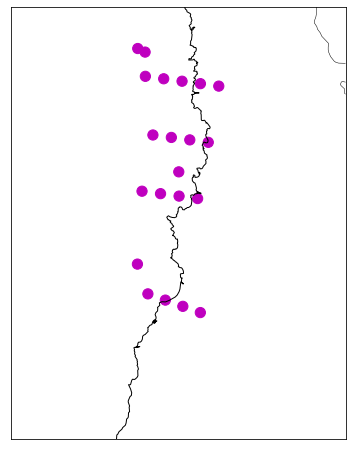

In [27]:
plot_quakedger(quakeledger_output_df)

## Chose an event
Now we want to have chose one of those events and prepare it as input for our shakyground service.

In [28]:
chosen_event = None

for i, val in enumerate(quakeledger_output_df): 
    event = quakeledger_output_df[i:i+1]
    eventId = event["eventID"].iloc[0]
    if eventId == "quakeml:quakeledger/80674999":
        chosen_event = event
        break

if chosen_event is None:
    raise Exception('Event 80674999 not found')

In [29]:
chosen_event

,eventID,agency,Identifier,year,month,day,hour,minute,second,timeUncertainty,...,magnitudeUncertainty,rake,rakeUncertainty,dip,dipUncertainty,strike,strikeUncertainty,type,probability,geometry
7,quakeml:quakeledger/80674999,GFZ,NaN,2019,1,1,0,0,0.0,NaN,...,NaN,90.0,NaN,20.0,NaN,9.0,NaN,expert,NaN,POINT (-71.65410 -32.93360)


In [30]:
chosen_event_as_quakeml = gfzwpsformatconversions.QuakeMLDataframe.from_dataframe(chosen_event).to_xml_string()

In [31]:
chosen_event_as_quakeml

'<ns0:eventParameters xmlns:ns0="http://quakeml.org/xmlns/bed/1.2" publicID="quakeml:quakeledger/0">\n  <ns0:event publicID="quakeml:quakeledger/80674999">\n    <ns0:preferredOriginID>quakeml:quakeledger/80674999</ns0:preferredOriginID>\n    <ns0:preferredMagnitudeID>quakeml:quakeledger/80674999</ns0:preferredMagnitudeID>\n    <ns0:type>earthquake</ns0:type>\n    <ns0:description>\n      <ns0:text>expert</ns0:text>\n    </ns0:description>\n    <ns0:origin publicID="quakeml:quakeledger/80674999">\n      <ns0:time>\n        <ns0:value>2019-01-01T00:00:00.000000Z</ns0:value>\n        <ns0:uncertainty>NaN</ns0:uncertainty>\n      </ns0:time>\n      <ns0:latitude>\n        <ns0:value>-32.9336</ns0:value>\n        <ns0:uncertainty>NaN</ns0:uncertainty>\n      </ns0:latitude>\n      <ns0:longitude>\n        <ns0:value>-71.6541</ns0:value>\n        <ns0:uncertainty>NaN</ns0:uncertainty>\n      </ns0:longitude>\n      <ns0:depth>\n        <ns0:value>42.7</ns0:value>\n        <ns0:uncertainty>Na

# Shakyground
Now lets use the chosen event to get the data of the shakemap.

In [32]:
ID_SHAKYGROUND = 'org.n52.gfz.riesgos.algorithm.impl.ShakygroundProcess'


In [33]:
execution_shakyground = server.execute(
    identifier=ID_SHAKYGROUND, 
    inputs=[
        ('quakeMLFile', wps.ComplexDataInput(chosen_event_as_quakeml)),
    ],
    output=[('shakeMapFile', True)]
)

wps.monitorExecution(execution_shakyground)
print('Successful: {}'.format(execution_shakyground.isSucceded()))

Successful: True


In [34]:
shakyground_output_reference = execution_shakyground.processOutputs[0].reference
shakyground_output = le.fromstring(requests.get(shakyground_output_reference).content)

In [35]:
execution_shakyground.processOutputs[0].reference

'http://rz-vm140.gfz-potsdam.de:80/wps/RetrieveResultServlet?id=d7458024-b518-427f-b643-e8242fca88e2shakeMapFile.2cdab2ff-aaed-43c4-aba9-3a2295079234'

Now we want to visualize the shakemap.

In [36]:
shakyground_output_intensity_df = gfzwpsformatconversions.Shakemap.from_xml(shakyground_output).to_intensity_geodataframe()

In [37]:
shakyground_output_intensity_df.head()

,LON,LAT,value_PGA,value_STDPGA,value_SA(0.3),value_STDSA(0.3),value_SA(1.0),value_STDSA(1.0),unit_PGA,unit_STDPGA,unit_SA(0.3),unit_STDSA(0.3),unit_SA(1.0),unit_STDSA(1.0),geometry
0,-73.616667,-30.808333,0.027395,0.805277,0.059483,0.845455,0.032501,0.754395,g,g,g,g,g,g,POINT (-73.61667 -30.80833)
1,-73.608333,-30.808333,0.027507,0.805277,0.059765,0.845455,0.032589,0.754395,g,g,g,g,g,g,POINT (-73.60833 -30.80833)
2,-73.600000,-30.808333,0.027620,0.805277,0.060049,0.845455,0.032677,0.754395,g,g,g,g,g,g,POINT (-73.60000 -30.80833)
3,-73.591667,-30.808333,0.027732,0.805277,0.060333,0.845455,0.032765,0.754395,g,g,g,g,g,g,POINT (-73.59167 -30.80833)
4,-73.583333,-30.808333,0.027846,0.805277,0.060619,0.845455,0.032854,0.754395,g,g,g,g,g,g,POINT (-73.58333 -30.80833)


In [38]:
raster = gfzwpsformatconversions.Shakemap.dataframe2raster(shakyground_output_intensity_df, 'LON', 'LAT', 'value_PGA')

In [39]:
event_dataframe = gfzwpsformatconversions.Shakemap.from_xml(shakyground_output).to_event_geodataframe_or_none()

In [40]:
def plot_shakemap(raster, events, additional_spacing=1):
    cmap = plt.get_cmap('YlOrBr')
    z = raster.raster.data
    y_count, x_count = z.shape
    x_s = np.linspace(raster.xmin, raster.xmax, x_count)
    # the image coordinates for ys go down
    y_s = np.linspace(raster.ymax, raster.ymin, y_count)
    
    # dont plot some values
    # to make the image not that full
    zz = np.ma.masked_array(z, z < 0.1)
    
    bbox = raster.bounds
    fig = plt.figure(figsize=(6, 12))
    mp = Basemap(projection='cyl', resolution='h', 
                 #lat_0=bbox[2], 
                 #lon_0=bbox[0],
                 llcrnrlon=bbox[0] - additional_spacing,
                 llcrnrlat=bbox[1] - additional_spacing,
                 urcrnrlon=bbox[2] + additional_spacing,
                 urcrnrlat=bbox[3] + additional_spacing
    )
    mp.arcgisimage(service='World_Shaded_Relief', xpixels = 2000, verbose=False)
    mp.drawcoastlines()
    mp.drawcountries()
    cs = mp.pcolormesh(x_s, y_s, zz, zorder=98, alpha=0.3, cmap=cmap)
    mp.colorbar(cs, extend='min')
    
    mp.scatter(events.geometry.x, events.geometry.y,
               zorder=99,
               marker='*',color='red',s = 30**2)
    plt.show()

/home/mruester/git/RIESGOS/gfzriesgos/wps-pipeline-notebook/wps-pipeline-notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/mruester/git/RIESGOS/gfzriesgos/wps-pipeline-notebook/wps-pipeline-notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


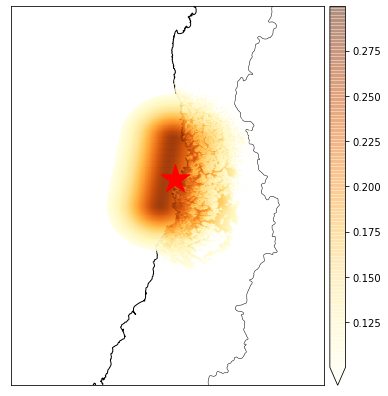

In [41]:
plot_shakemap(raster, event_dataframe)

# Deus
At the moment the last service to use here.

In [42]:
ID_DEUS = 'org.n52.gfz.riesgos.algorithm.impl.DeusProcess'

In [43]:
len(le.tostring(shakyground_output))

22768373

In [44]:
execution_deus = server.execute(
    identifier=ID_DEUS, 
    inputs=[
        ('schema', 'SARA_v1.0'),
        ('exposure', wps.ComplexDataInput(assetmaster_output_pure)),
        ('fragility', wps.ComplexDataInput(modelprop_output_pure)),
        ('intensity', wps.ComplexDataInput(le.tostring(shakyground_output)))
    ],
    output=[
        ('updated_exposure', True),
        ('transition', True),
        ('damage', True),
    ]
)

wps.monitorExecution(execution_deus)
print('Successful: {}'.format(execution_deus.isSucceded()))

Successful: True


In [45]:
updated_exposure_model_reference = execution_deus.processOutputs[0].reference
updated_exposure_model_df = gpd.read_file(updated_exposure_model_reference, )

In [46]:
updated_exposure_model_transitions =  requests.get(execution_deus.processOutputs[1].reference).json()

In [47]:
str(updated_exposure_model_transitions)[:3000]

"{'features': [{'geometry': {'coordinates': [[[[-71.48737699955441, -32.995691999934614], [-71.48627500052956, -32.99721700014356], [-71.48756500025739, -33.000142999684215], [-71.49026700003029, -32.99759600019429], [-71.49016699980027, -32.99691399994977], [-71.4875840003787, -32.99563599984297], [-71.48737699955441, -32.995691999934614]]]], 'type': 'MultiPolygon'}, 'type': 'Feature', 'properties': {'gid': '100', 'transitions': {'n_buildings': [0.016902, 0.162865, 0.859993, 9.507687, 0.003827, 0.077439, 0.508284, 12.62634, 0.000341, 0.004826, 0.035774, 1.321468, 9e-06, 1e-06, 3e-05, 0.009409, 4e-06, 0.0, 1.5e-05, 0.004642, 0.000781, 0.00096, 0.01803, 3.019489, 0.03889, 0.183948, 0.411262, 0.365105, 0.0, 0.0, 4e-06, 0.03657, 0.004599, 0.042479, 0.170524, 0.720087, 0.0, 0.0, 1e-06, 0.009143, 0.000499, 0.010101, 0.066298, 1.646914, 5.1e-05, 5.5e-05, 0.001039, 1.912305, 2e-06, 2.8e-05, 0.000257, 0.259007, 1e-05, 1.1e-05, 0.000197, 0.362679, 1e-06, 9e-06, 7.9e-05, 0.079694], 'replacement_

In [48]:
updated_exposure_model_df.head()

,gid,expo,geometry
0,100,"{'Taxonomy': ['MUR-ADO-H1-2', 'MUR-ADO-H1-2', ...","MULTIPOLYGON (((-71.48738 -32.99569, -71.48628..."
1,1002,"{'Taxonomy': ['MUR-ADO-H1-2', 'MUR-H1-3', 'MUR...","MULTIPOLYGON (((-71.49692 -33.19048, -71.52102..."
2,1003,"{'Taxonomy': ['MUR-ADO-H1-2', 'MUR-H1-3', 'MUR...","MULTIPOLYGON (((-71.52951 -32.99708, -71.52926..."
3,1004,"{'Taxonomy': ['MUR-ADO-H1-2', 'MUR-H1-3', 'MUR...","MULTIPOLYGON (((-71.52717 -33.01308, -71.52598..."
4,1005,"{'Taxonomy': ['MUR-ADO-H1-2', 'MUR-H1-3', 'MUR...","MULTIPOLYGON (((-71.54862 -33.08271, -71.54903..."


In [49]:
damage_reference = execution_deus.processOutputs[2].reference
damage = requests.get(damage_reference).json()

In [50]:
damage_reference

'http://rz-vm140.gfz-potsdam.de:80/wps/RetrieveResultServlet?id=731ac02d-047b-42fe-9aa0-ad0e248f26a5damage.9730fcaf-e9d7-4600-ba26-9d6234694500'

In [51]:
str(damage)[:3000]

"{'features': [{'geometry': {'coordinates': [[[[-71.48737699955441, -32.995691999934614], [-71.48627500052956, -32.99721700014356], [-71.48756500025739, -33.000142999684215], [-71.49026700003029, -32.99759600019429], [-71.49016699980027, -32.99691399994977], [-71.4875840003787, -32.99563599984297], [-71.48737699955441, -32.995691999934614]]]], 'type': 'MultiPolygon'}, 'type': 'Feature', 'properties': {'loss_value': 1614000.7805206997, 'gid': '100', 'loss_unit': 'USD'}}, {'geometry': {'coordinates': [[[[-71.49691799976671, -33.19048300023117], [-71.52102199979039, -33.2039020004546], [-71.52427099995492, -33.19601399990537], [-71.5222619995992, -33.187941000374906], [-71.5101499996049, -33.182121999851525], [-71.49691600047437, -33.190435999619694], [-71.49691799976671, -33.19048300023117]]]], 'type': 'MultiPolygon'}, 'type': 'Feature', 'properties': {'loss_value': 0.0, 'gid': '1002', 'loss_unit': 'USD'}}, {'geometry': {'coordinates': [[[[-71.52951199959017, -32.99708099987643], [-71.52

In [52]:
sum_eq = 0
for i, feature in enumerate(damage["features"]):
    sum_eq += feature["properties"]["loss_value"]
print("%.2f USD" % sum_eq)

27637483019.51 USD


In [53]:
map_eq = ipyl.Map(center=[-33.094296, -71.613629], zoom=12)
label_eq = ipyw.Label(layout=ipyw.Layout(width='100%'))

maximum_eq = 0
data_eq = damage.copy()

for feature in data_eq['features']:
    maximum_eq = max(maximum_eq, feature['properties']['loss_value'])

for feature in data_eq['features']:
    loss_value = feature['properties']['loss_value']
    feature['properties']['style'] = {
        'color': 'grey',
        'weight': 1,
        'fillColor': 'red',
        'fillOpacity': loss_value / maximum_eq
    }

layer_eq = ipyl.GeoJSON(data=data_eq, hover_style={'fillColor': 'lightblue', 'fillOpacity': 1.0})

def hover_handler_eq(event=None, id=None, feature=None, properties=None):
    props = feature["properties"].copy()
    del props["style"]
    label_eq.value = str(props)

layer_eq.on_hover(hover_handler_eq)
map_eq.add_layer(layer_eq)

ipyw.VBox([map_eq, label_eq])

## Tsunami intensities

In [54]:
server_tsunami = wps.WebProcessingService("http://tsunami-wps.awi.de/wps")
execution_tsunami = server_tsunami.execute(
    identifier="get_tsunamap", 
    inputs=[
        ('lon', wps.ComplexDataInput("-71.6541")),
        ('lat', wps.ComplexDataInput("-32.9336")),
        ('mag', wps.ComplexDataInput("8.0"))
    ],
    output=[('tsunamap', True)]
)

wps.monitorExecution(execution_tsunami)
print('Successful: {}'.format(execution_tsunami.isSucceded()))

Successful: True


In [55]:
tsunami_shakemap_reference = execution_tsunami.processOutputs[0].reference

In [56]:
tsunami_shakemap_reference

'http://tsunami-wps.awi.de/outputs/535e1d4c-5c9b-11eb-9c7f-02420a030102/input.xml'

## Calculate tsunami damage

First get fragility functions for SUPPASRI:

In [57]:
execution_modelprop_sup = server.execute(
    identifier=ID_MODELPROP, 
    inputs=[
        ('schema', 'SUPPASRI2013_v2.0'),
        ('assetcategory', 'buildings'),
        ('losscategory', 'structural'),
        ('taxonomies', ''),
    ],
    output=[('selectedRows', True)]
)

wps.monitorExecution(execution_modelprop_sup)
print('Successful: {}'.format(execution_modelprop_sup.isSucceded()))

Successful: True


In [58]:
modelprop_output_sup_reference = execution_modelprop_sup.processOutputs[0].reference
modelprop_output_sup_pure = requests.get(modelprop_output_sup_reference).text

Calling deus this time with updated exposure of the previous call and tsunami intensities:

In [59]:
updated_exposure_model_pure = requests.get(updated_exposure_model_reference).text
tsunami_shakemap_pure = requests.get(tsunami_shakemap_reference).text

In [60]:
execution_deus_tsunami = server.execute(
    identifier=ID_DEUS, 
    inputs=[
        ('schema', 'SARA_v1.0'),
        ('exposure', wps.ComplexDataInput(updated_exposure_model_pure)),
        ('fragility', wps.ComplexDataInput(modelprop_output_sup_pure)),
        ('intensity', wps.ComplexDataInput(tsunami_shakemap_pure))
    ],
    output=[
        ('updated_exposure', True),
        ('transition', True),
        ('damage', True),
    ]
)

wps.monitorExecution(execution_deus_tsunami)
print('Successful: {}'.format(execution_deus_tsunami.isSucceded()))

Successful: True


In [61]:
updated_exposure_model_ts_reference = execution_deus_tsunami.processOutputs[0].reference
updated_exposure_model_ts_df = gpd.read_file(updated_exposure_model_reference, )

In [62]:
updated_exposure_model_transitions_ts =  requests.get(execution_deus_tsunami.processOutputs[1].reference).json()

In [63]:
str(updated_exposure_model_transitions_ts)[:3000]

"{'features': [{'geometry': {'coordinates': [[[[-71.48737699955441, -32.995691999934614], [-71.48627500052956, -32.99721700014356], [-71.48756500025739, -33.000142999684215], [-71.49026700003029, -32.99759600019429], [-71.49016699980027, -32.99691399994977], [-71.4875840003787, -32.99563599984297], [-71.48737699955441, -32.995691999934614]]]], 'type': 'MultiPolygon'}, 'type': 'Feature', 'properties': {'gid': '100', 'transitions': {'n_buildings': [], 'replacement_costs_usd_bdg': [], 'taxonomy': [], 'to_damage_state': [], 'from_damage_state': []}}}, {'geometry': {'coordinates': [[[[-71.49691799976671, -33.19048300023117], [-71.52102199979039, -33.2039020004546], [-71.52427099995492, -33.19601399990537], [-71.5222619995992, -33.187941000374906], [-71.5101499996049, -33.182121999851525], [-71.49691600047437, -33.190435999619694], [-71.49691799976671, -33.19048300023117]]]], 'type': 'MultiPolygon'}, 'type': 'Feature', 'properties': {'gid': '1002', 'transitions': {'n_buildings': [], 'replace

In [64]:
updated_exposure_model_ts_df.head()

,gid,expo,geometry
0,100,"{'Taxonomy': ['MUR-ADO-H1-2', 'MUR-ADO-H1-2', ...","MULTIPOLYGON (((-71.48738 -32.99569, -71.48628..."
1,1002,"{'Taxonomy': ['MUR-ADO-H1-2', 'MUR-H1-3', 'MUR...","MULTIPOLYGON (((-71.49692 -33.19048, -71.52102..."
2,1003,"{'Taxonomy': ['MUR-ADO-H1-2', 'MUR-H1-3', 'MUR...","MULTIPOLYGON (((-71.52951 -32.99708, -71.52926..."
3,1004,"{'Taxonomy': ['MUR-ADO-H1-2', 'MUR-H1-3', 'MUR...","MULTIPOLYGON (((-71.52717 -33.01308, -71.52598..."
4,1005,"{'Taxonomy': ['MUR-ADO-H1-2', 'MUR-H1-3', 'MUR...","MULTIPOLYGON (((-71.54862 -33.08271, -71.54903..."


In [65]:
damage_ts_reference = execution_deus_tsunami.processOutputs[2].reference
damage_ts = requests.get(damage_ts_reference).json()

In [66]:
str(damage_ts)[:3000]

"{'features': [{'geometry': {'coordinates': [[[[-71.48737699955441, -32.995691999934614], [-71.48627500052956, -32.99721700014356], [-71.48756500025739, -33.000142999684215], [-71.49026700003029, -32.99759600019429], [-71.49016699980027, -32.99691399994977], [-71.4875840003787, -32.99563599984297], [-71.48737699955441, -32.995691999934614]]]], 'type': 'MultiPolygon'}, 'type': 'Feature', 'properties': {'loss_value': 0.0, 'gid': '100', 'loss_unit': 'USD'}}, {'geometry': {'coordinates': [[[[-71.49691799976671, -33.19048300023117], [-71.52102199979039, -33.2039020004546], [-71.52427099995492, -33.19601399990537], [-71.5222619995992, -33.187941000374906], [-71.5101499996049, -33.182121999851525], [-71.49691600047437, -33.190435999619694], [-71.49691799976671, -33.19048300023117]]]], 'type': 'MultiPolygon'}, 'type': 'Feature', 'properties': {'loss_value': 0.0, 'gid': '1002', 'loss_unit': 'USD'}}, {'geometry': {'coordinates': [[[[-71.52951199959017, -32.99708099987643], [-71.5292640003219, -3

In [67]:
sum_ts = 0
for i, feature in enumerate(damage_ts["features"]):
    sum_ts += feature["properties"]["loss_value"]
print("%.2f USD" % sum_ts)

540334896.95 USD


In [68]:
# Map and label widgets
map_ts = ipyl.Map(center=[-33.094296, -71.613629], zoom=12)
label_ts = ipyw.Label(layout=ipyw.Layout(width='100%'))

maximum_ts = 0
data_ts = damage_ts.copy()

for feature in data_ts['features']:
    maximum_ts = max(maximum_ts, feature['properties']['loss_value'])

for feature in data_ts['features']:
    loss_value = feature['properties']['loss_value']
    feature['properties']['style'] = {
        'color': 'grey',
        'weight': 1,
        'fillColor': 'red',
        'fillOpacity': loss_value / maximum_ts
    }

layer_ts = ipyl.GeoJSON(data=data_ts, hover_style={'fillColor': 'lightblue', 'fillOpacity': 1.0})

def hover_handler_ts(event=None, id=None, feature=None, properties=None):
    props = feature["properties"].copy()
    del props["style"]
    label_ts.value = str(props)

layer_ts.on_hover(hover_handler_ts)
map_ts.add_layer(layer_ts)

ipyw.VBox([map_ts, label_ts])